<a href="https://colab.research.google.com/github/Partha0003/Appian/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("Appian AI Application Challenge 2026")

Appian AI Application Challenge 2026


In [11]:
import pandas as pd


print(" Loading datasets...")
input_df = pd.read_csv('operations_input_state_FINAL.csv')
insights_df = pd.read_csv('operations_decision_insights_FINAL.csv')


full_data = pd.merge(input_df, insights_df, on='Case_ID')

print(f" Data Loaded. Total Rows: {len(full_data)}")

 Loading datasets...
 Data Loaded. Total Rows: 1200


In [13]:
import joblib


clean_df = full_data.dropna(subset=['Estimated_Time_To_Breach_Mins'])

print(f" Filtered Data for Training: {len(clean_df)} rows (removed Low Risk/NaN cases)")


features = [
    'Case_Type', 'Complexity_Score', 'SLA_Limit_Mins',
    'Queue_Name', 'Queue_Depth', 'Active_Agents',
    'Avg_Handle_Time_Mins', 'Load_Index',
    'Arrival_Hour', 'Day_Of_Week',
    'Agent_Skill_Level', 'Automation_Level'
]

X = clean_df[features]
y = clean_df['Estimated_Time_To_Breach_Mins']

X_encoded = pd.get_dummies(X, columns=['Case_Type', 'Queue_Name', 'Agent_Skill_Level', 'Automation_Level'], drop_first=True)


joblib.dump(list(X_encoded.columns), 'Estimated_Time_To_breach_Mins.pkl')
print(" Column structure saved to 'Estimated_Time_To_breach_Mins'")

 Filtered Data for Training: 1005 rows (removed Low Risk/NaN cases)
 Column structure saved to 'Estimated_Time_To_breach_Mins'


In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

print(" Training Time-to-Breach Model...")
model.fit(X_train, y_train)

model.save_model("est_breach_model.json")
print(" Training Complete. Model saved as 'est_breach_model.json'")

 Training Time-to-Breach Model...
 Training Complete. Model saved as 'est_breach_model.json'


In [16]:
from sklearn.metrics import r2_score, mean_absolute_error


predictions = model.predict(X_test)

r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(" Model Evaluation Report:")
print(f"---------------------------")
print(f"Accuracy (R2 Score): {r2:.3f} (Closer to 1.0 is better)")
print(f"Average Error: +/- {mae:.1f} minutes")

 Model Evaluation Report:
---------------------------
Accuracy (R2 Score): 0.998 (Closer to 1.0 is better)
Average Error: +/- 2.1 minutes


/tmp/ipython-input-308299748.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Case_Category', y=predictions, data=test_df_viz, ax=axes[3], palette="Blues")


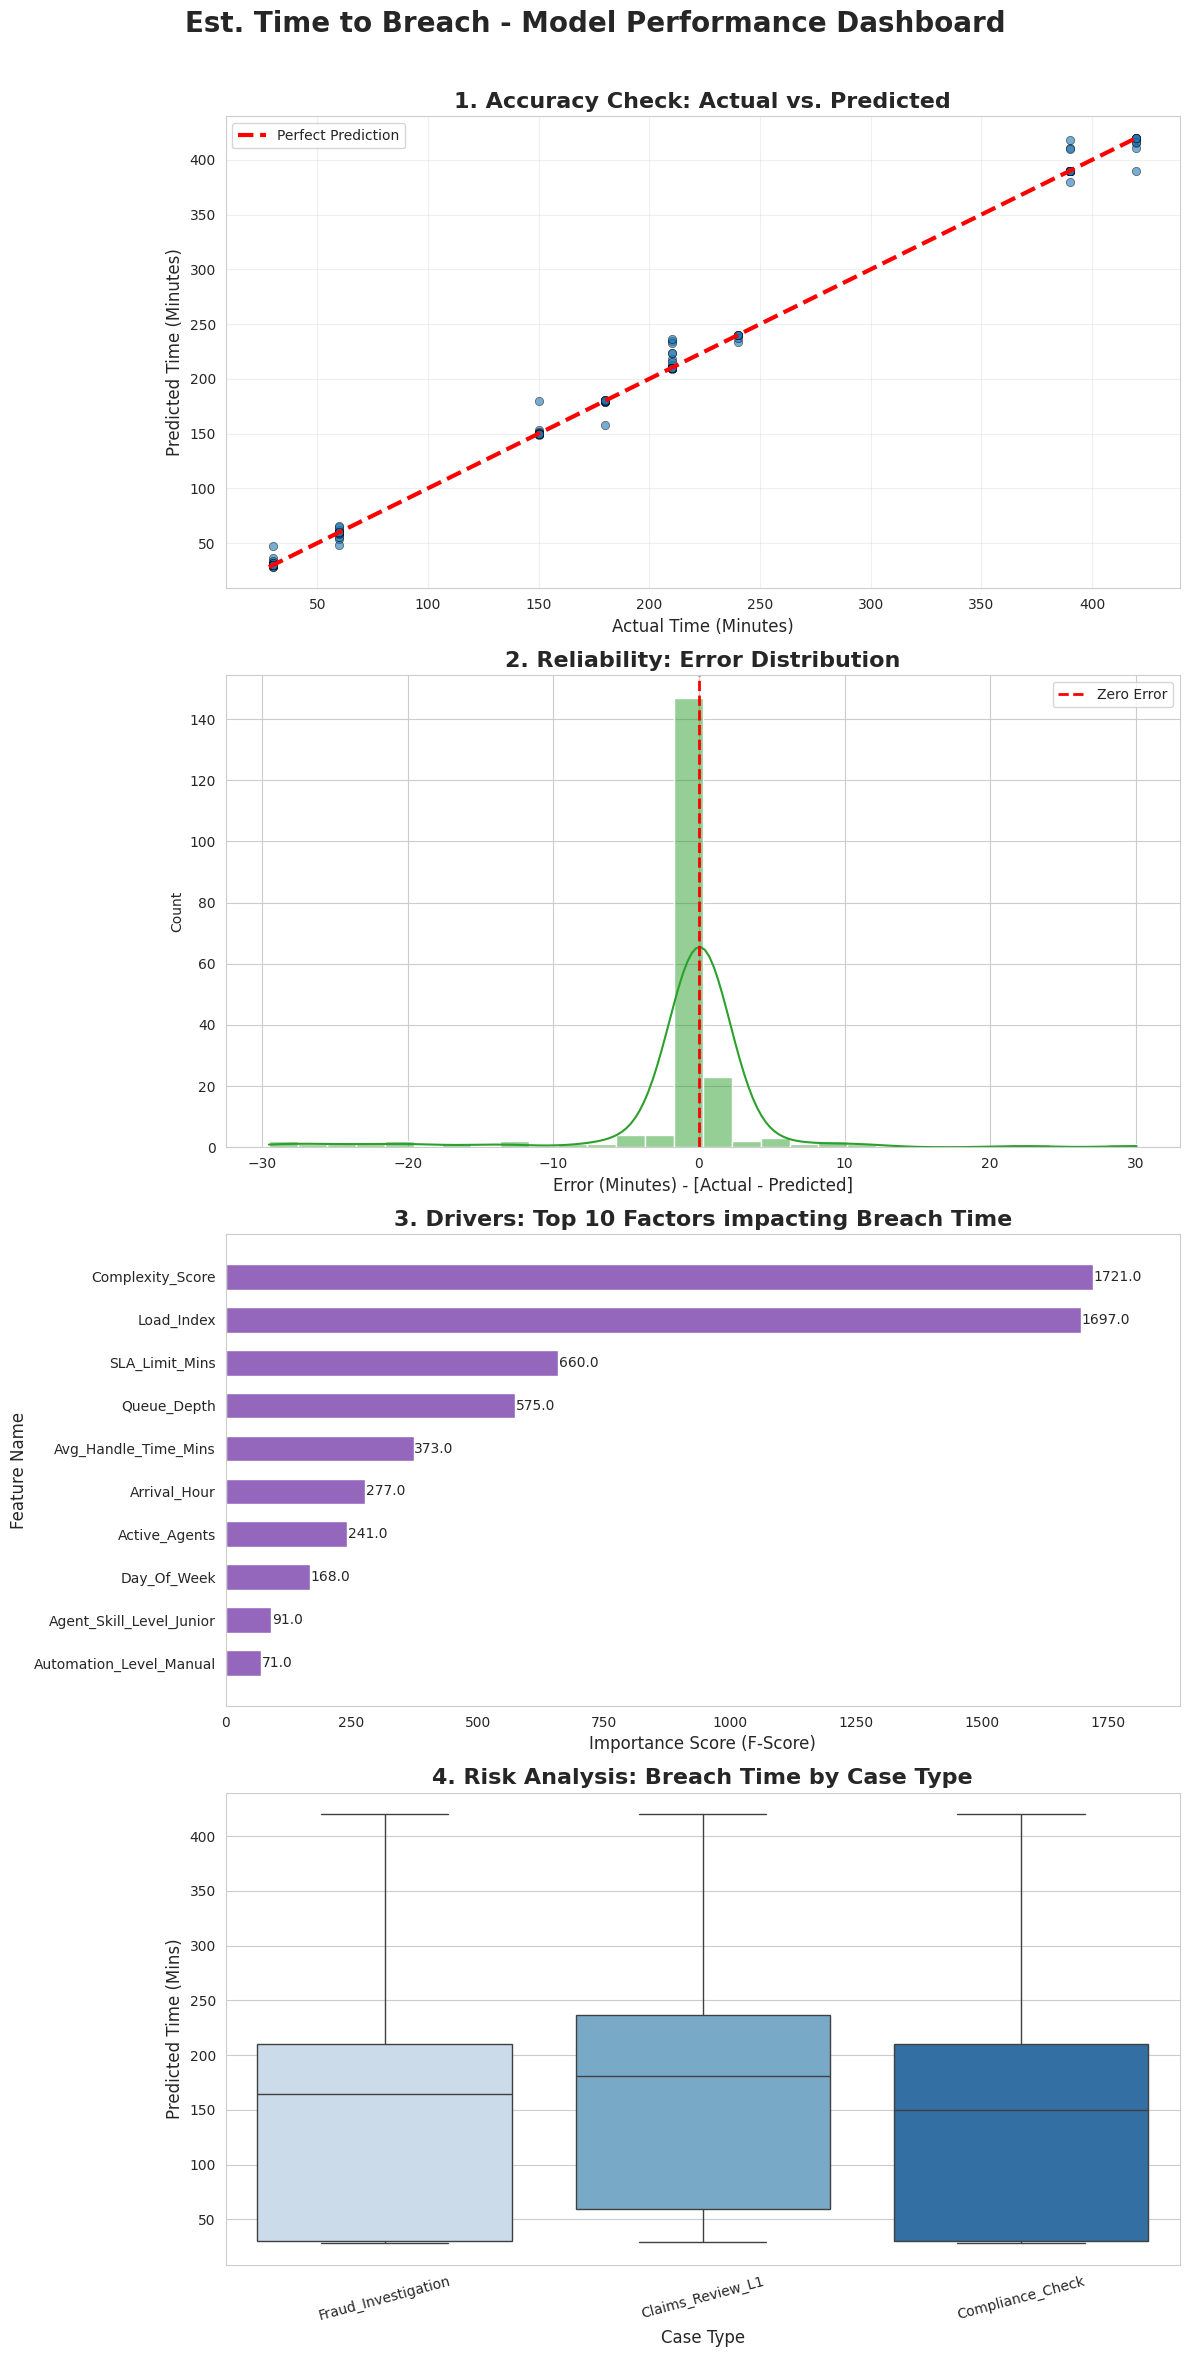

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set_style("whitegrid")


fig, axes = plt.subplots(4, 1, figsize=(12, 24))
fig.suptitle('Est. Time to Breach - Model Performance Dashboard', fontsize=20, fontweight='bold', y=0.99)


sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color='#1f77b4', edgecolor='k', ax=axes[0])


min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction')

axes[0].set_title("1. Accuracy Check: Actual vs. Predicted", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Actual Time (Minutes)", fontsize=12)
axes[0].set_ylabel("Predicted Time (Minutes)", fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)


residuals = y_test - predictions
sns.histplot(residuals, bins=30, kde=True, color='#2ca02c', ax=axes[1])

axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_title('2. Reliability: Error Distribution', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Error (Minutes) - [Actual - Predicted]', fontsize=12)
axes[1].legend()


xgb.plot_importance(model, ax=axes[2], max_num_features=10, height=0.6, color='#9467bd', grid=False)
axes[2].set_title('3. Drivers: Top 10 Factors impacting Breach Time', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Importance Score (F-Score)', fontsize=12)
axes[2].set_ylabel('Feature Name', fontsize=12)


test_df_viz = X_test.copy()

case_cols = [c for c in test_df_viz.columns if c.startswith('Case_Type_')]

if case_cols:
    test_df_viz['Case_Category'] = test_df_viz[case_cols].idxmax(axis=1).apply(lambda x: x.replace('Case_Type_', ''))

    sns.boxplot(x='Case_Category', y=predictions, data=test_df_viz, ax=axes[3], palette="Blues")
    axes[3].set_title('4. Risk Analysis: Breach Time by Case Type', fontsize=16, fontweight='bold')
    axes[3].set_ylabel('Predicted Time (Mins)', fontsize=12)
    axes[3].set_xlabel('Case Type', fontsize=12)
    axes[3].tick_params(axis='x', rotation=15)
else:
    axes[3].text(0.5, 0.5, "Case Type data not found in X_test", ha='center')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.01, 1, 0.98])
plt.show()